In [1]:
import xml.etree.ElementTree as ET
from collections import defaultdict
from os import path, listdir, makedirs, stat
import re
import pickle

def extract_info(dialogue):
    words_tree = ET.parse(path.join(basedata, dialogue + '_words.xml'))
    words_root = words_tree.getroot()
    words = {}
    for word in words_root:
        words[int(word.attrib['id'].strip('word_'))] = word.text
    #moves
    moves_tree = ET.parse(path.join(markables, dialogue + '_move_markables.xml'))
    moves_root = moves_tree.getroot()
    moves_spans = defaultdict(list)
    success_move = {}
    i = 0
    for move in moves_root:
        id_move = move.attrib['span'].replace('word_', '').split('..')
        try:
            success = move.attrib['move_world']
        except:
            success = move.attrib['world']
        if len(id_move) == 2:
            id_move = (int(id_move[0]), int(id_move[1]))
        else:
            id_move = (int(id_move[0]), int(id_move[0]))
        moves_spans[i] = id_move
        success_move[id_move] = success
        i += 1
    utt_tree = ET.parse(path.join(markables, dialogue + '_utterance_markables.xml'))
    utts_root = utt_tree.getroot()
    utts_speaker = defaultdict(list)
    for utt in utts_root:
        span =  utt.attrib['span'].replace('word_', '').split('..')
        if len(span) == 2:
            span = (int(span[0]), int(span[1]))
        else:
            span = (int(span[0]), int(span[0]))
        speaker =  utt.attrib['speaker']
        utts_speaker[speaker].append(span)
    #associate referring expressions to objects
    ref_tree = ET.parse(path.join(markables, dialogue + '_ref_markables.xml'))
    refs_root = ref_tree.getroot()
    refs_objects = defaultdict(list)
    for ref in refs_root:
        ref_type = ref.attrib['referent_type']
        form =  ref.attrib['form']
        span =  ref.attrib['span'].replace('word_', '').split('..')
        if len(span) == 2:
            span = (int(span[0]), int(span[1]))
        else:
            span = (int(span[0]), int(span[0]))
        try:
            item =  ref.attrib['item_id']
            refs_objects[item].append((span, form, ref_type))
        except:
            pass
    moves_utt = defaultdict(dict)
    for s in utts_speaker:
        for utt in utts_speaker[s]:
            for m in moves_spans:
                if utt[0] >= moves_spans[m][0] and utt[0] <= moves_spans[m][1]:
                    if not moves_utt[moves_spans[m]].has_key(s):
                        moves_utt[moves_spans[m]][s] = []
                    moves_utt[moves_spans[m]][s].append(utt)
    moves_ref = defaultdict(dict)
    for obj in refs_objects:
        speaker = ''
        move = ''
        for ref in refs_objects[obj]:
            word_span = ref[0]
            for m in moves_utt:
                for s in moves_utt[m]:
                    for utt in moves_utt[m][s]:
                        if word_span[0] >= utt[0] and word_span[0] <= utt[1]:
                            speaker = s
                            move = m
                            if not moves_ref[move].has_key(speaker):
                                moves_ref[move][speaker] = {}
                            if not moves_ref[move][speaker].has_key(obj):
                                moves_ref[move][speaker][obj] = []
                            moves_ref[move][speaker][obj].append(ref)
                            break
    moves_ref_words = defaultdict(dict)
    for m in moves_ref:
        for s in moves_ref[m]:
            for o in moves_ref[m][s]:
                for ref in moves_ref[m][s][o]:
                    span = ref[0]
                    form = ref[1]
                    ref_type = ref[2]
                    if len(span) == 1:
                        exp = words[span[0]]
                    else:
                        exp = ''
                        i = span[0]
                        while i <= span[1]:
                            if i != span[1]:
                                exp += words[i] + ' '
                            else:
                                exp += words[i]
                            i += 1
                    if not moves_ref_words[m].has_key(s):
                        moves_ref_words[m][s] = {}
                    if not moves_ref_words[m][s].has_key(o):
                        moves_ref_words[m][s][o] = {}
                    if not moves_ref_words[m][s][o].has_key(ref_type):
                        moves_ref_words[m][s][o][ref_type] = []
                    #remove hesitations, and internal tags
                    exp = re.sub(r'<.*>', '', exp)
                    exp = re.sub(r'</.*>', '', exp)
                    exp = re.sub(r'\(.*\)', '', exp)
                    exp = re.sub(r'[\(\)\[\]\.]','', exp)
                    exp = exp.lower()
                    exp_sp = exp.split(' ')
                    if len(exp_sp) == 1 and exp.endswith("'s"):
                        exp = exp.replace("'s", '')
                    moves_ref_words[m][s][o][ref_type].append((exp, span, form))
            for t in moves_ref_words[m][s][o]:
                moves_ref_words[m][s][o][t] = sorted(moves_ref_words[m][s][o][ref_type], key=lambda tup: tup[1][0])
    return moves_ref_words, success_move



In [15]:
#associate word ids to words

data_folder = 'PentoCorpora'
games = listdir(data_folder)
games = ['Push_to_Talk_Corpus']
print games
for g in games:
    folder = path.join(data_folder, g)
    basedata = path.join(folder, 'Basedata')
    markables = path.join(folder,'Markables')
    dialogues = []
    output_folder = g.replace('/', '.')
    output_folder = path.join('Dataset', output_folder)
    for doc in listdir(basedata):
        if doc.endswith('_words.xml'):
            dialogue = doc.replace('_words.xml', '')
            dialogues.append(dialogue)
    try:
        stat(output_folder)
    except:
        makedirs(output_folder)
    try:
        stat(output_folder+ '/RefExp')
    except:
        makedirs(output_folder+ '/RefExp')
    try:
        stat(output_folder+ '/Success')
    except:
        makedirs(output_folder+ '/Success')
    for d in dialogues:
        try: 
            r, s = extract_info(d)
            pickle.dump(r, open( path.join(output_folder + '/RefExp', d + "_refexps.p"), "wb" ) )
            pickle.dump(s, open( path.join(output_folder + '/Success', d + "_movesuccess.p"), "wb" ) )
            print d
        except:
            pass

['Push_to_Talk_Corpus']
FTT_2006-02-13pair1
FTT_2006-03-27Pair1
FTT_2006-03-28pair2
FTT_2006-06-22pair1
FTT_2006-06-22pair2
PTT_2006-02-13pair2a
PTT_2006-03-27Pair2a
PTT_2006-03-27pair3a
PTT_2006-03-28pair1
PTT_2006-06-22pair3a


In [16]:
listdir('Dataset/Push_to_Talk_Corpus/RefExp/')

['FTT_2006-02-13pair1_refexps.p',
 'FTT_2006-03-27Pair1_refexps.p',
 'FTT_2006-03-28pair2_refexps.p',
 'FTT_2006-06-22pair1_refexps.p',
 'FTT_2006-06-22pair2_refexps.p',
 'PTT_2006-02-13pair2a_refexps.p',
 'PTT_2006-03-27Pair2a_refexps.p',
 'PTT_2006-03-27pair3a_refexps.p',
 'PTT_2006-03-28pair1_refexps.p',
 'PTT_2006-06-22pair3a_refexps.p']

In [25]:
import numpy as np

corpus = 'Push_to_Talk_Corpus'

dataset = []
for name in listdir('Dataset/'+ corpus +'/RefExp/'):
    with open("Dataset/"+ corpus +"/RefExp/" + name) as handle:
        d = pickle.load(handle)
        dataset.append(d)
            

        
print 'Number of words per game:' 
print '_________________________\n'
        
keys = [game.keys() for game in dataset]

        
lengths = [max(d, key=lambda tup: tup[1])[1] for d in dataset]

print lengths
    
print '\n'

mean = np.mean(lengths)

print 'mean' ,mean

print '\n'

std_dev = np.var(lengths)**.5

print 'std_dev', std_dev

Number of words per game:
_________________________

[3519, 3607, 3556, 5143, 5688, 3038, 1596, 3677, 3353, 1776]


mean 3495.3


std_dev 1198.55296504




Objects:
_______

total: 4263
mean: 250.764705882
std_dev: 248.259477495


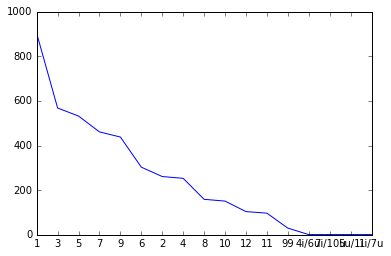

[('1', 902), ('10', 151), ('11', 97), ('12', 104), ('1i/7u', 1), ('2', 261), ('3', 568), ('4', 253), ('4i/6u', 1), ('5', 532), ('5u/1i', 1), ('6', 303), ('7', 461), ('7i/10u', 1), ('8', 159), ('9', 438), ('99', 30)]


In [112]:
# data dict structure
# {(start_i, end_i):{speaker:{obj_id:{ref_type:[refs_exp_ls]}}}}

from collections import defaultdict

corpus = 'Push_to_Talk_Corpus'

dataset = []
for name in listdir('Dataset/'+ corpus +'/RefExp/'):
    with open("Dataset/"+ corpus +"/RefExp/" + name) as handle:
        d = pickle.load(handle)
        dataset.append(d)

#print dataset[0]

print 'Objects:'
print '_______\n'

objects = [obj_dict.keys() for d in dataset for speaker_dict in d.values() for obj_dict in speaker_dict.values()]


object_ref_exp_list = ([(obj, sum(len(v) for v in type_dict.values())) for d in dataset for speaker_dict in d.values()
                                        for obj_dict in speaker_dict.values() for obj, type_dict in obj_dict.iteritems()])

d = defaultdict(int)

for obj, count in object_ref_exp_list:
    d[obj] += count

print 'total:', sum(d.values())
print 'mean:', np.mean(d.values())
print 'std_dev:', np.var(d.values())**.5


import matplotlib.pyplot as plt
%matplotlib inline

objs, counts = list(zip(*sorted(d.iteritems(), key=lambda tup: tup[1], reverse=True)))

plt.plot(range(len(objs)), counts)
plt.xticks(range(len(objs)), objs)
plt.show()

print sorted(d.iteritems())

mean lens:  2.76057254392
var lens:  9.22959706972


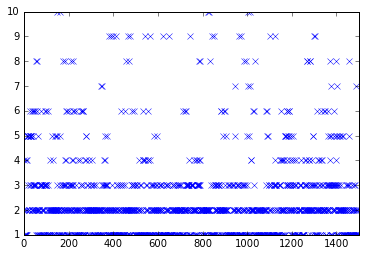

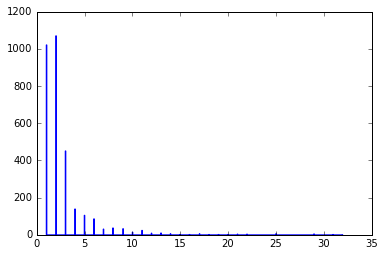

[(2, 1070), (1, 1021), (3, 451), (4, 139), (5, 105), (6, 86), (8, 37), (9, 33), (7, 31), (11, 24), (10, 14), (13, 10), (12, 9), (14, 6), (17, 6), (25, 6), (29, 5), (21, 4), (22, 4), (15, 2), (16, 2), (18, 2), (19, 2), (20, 2), (31, 2), (32, 1)]
3074


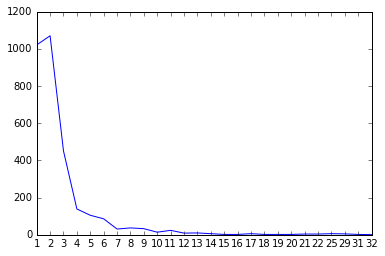

In [264]:
# data dict structure
# {(start_i, end_i):{speaker:{obj_id:{ref_type:[refs_exp_ls]}}}}

corpus = 'Push_to_Talk_Corpus'

dataset = []
for name in listdir('Dataset/'+ corpus +'/RefExp/'):
    with open("Dataset/"+ corpus +"/RefExp/" + name) as handle:
        d = pickle.load(handle)
        dataset.append(d)
        


expressions = [e.values()[0] for d in dataset for speaker_dict in d.values() 
               for obj_dict in speaker_dict.values() for type_dict in speaker_dict.values() for e in type_dict.values()] 

#unique_types = set(t for t_ls in types for t in t_ls)

#print expressions

get_len = lambda exp_ls: exp_ls[1][1] - exp_ls[1][0] + 1 

#get_len = lambda exp_ls: exp_ls[0]

lens = [get_len(e) for e_ls in expressions for e in e_ls]

print 'mean lens: ', np.mean(lens)
print 'var lens: ', np.var(lens)



#print lens

plt.plot(range(len(lens)), lens, 'x')

plt.axis([0, 1500, 1, 10,])

plt.show()

#[(2, 1070), (1, 1021), 
#(3, 451), 
#(4, 139), (5, 105), (6, 86), 
#(8, 37), (9, 33), (7, 31), (11, 24), 
#(10, 14), (13, 10), (12, 9), 
#(14, 6), (17, 6), (25, 6), (29, 5), (21, 4), (22, 4), 
#(15, 2), (16, 2), (18, 2), (19, 2), (20, 2), (31, 2), (32, 1)]
#bins = [2, 3, 6, 10, 13, 19, 26]

n, bins, patches = plt.hist(lens, 500, histtype='step')#, normed=True)
plt.show()

from collections import Counter

len_counts = Counter(lens)

print len_counts.most_common()

ls, l_counts = list(zip(*len_counts.iteritems()))

print sum(l_counts)

plt.plot(range(len(ls)), l_counts)

plt.xticks(range(len(ls)), ls)

plt.show()

C:\Program Files\Anaconda\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda\lib\site-packages\ipykernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log


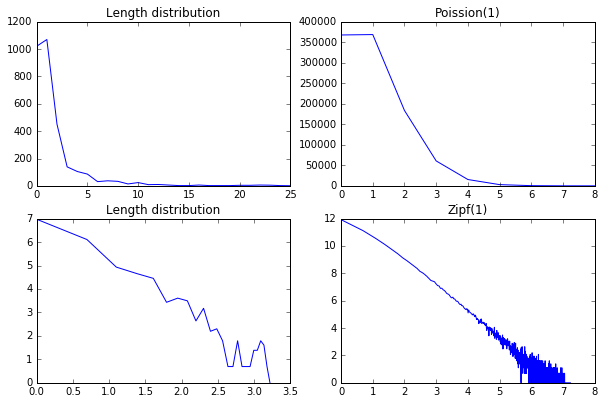

In [265]:
from numpy.random import poisson, zipf
from collections import Counter


fig = plt.figure(figsize=[10, 10])
plot11 = fig.add_subplot(321)
plot11.set_title('Length distribution')
plot12 = fig.add_subplot(322)
plot12.set_title('Poission(1)')
plot21 = fig.add_subplot(323)
plot21.set_title('Length distribution')
plot22 = fig.add_subplot(324)
plot22.set_title('Zipf(1)')

plot11.plot(range(len(ls)), l_counts)
plot21.plot(np.log(range(len(ls))), np.log(l_counts))

#plot11.xticks(range(len(ls)), ls)

xs = poisson(1, 1000000)

x_counts = Counter(xs)

x_ls, x_counts = list(zip(*x_counts.iteritems()))

plot12.plot(range(len(x_ls)), x_counts)

###

xs = zipf(2, 1000000)

x_counts = Counter(xs)

x_ls, x_counts = list(zip(*x_counts.iteritems()))

plot22.plot(np.log(range(len(x_ls))), np.log(x_counts))

plt.show()

In [338]:
### KL divergence

num_expressions = float(sum(l_counts))


from math import factorial, e

### Empirical length distribution - Poisson(lambda=1)

poisson_pdf = lambda length: (1**length)*(e**-1)/factorial(length)

emp_pdf = [(length, length_count/num_expressions) for length, length_count in len_counts.iteritems()]

kl_emp_poiss = sum(emp_prob*np.log(emp_prob/poisson_pdf(length)) for length, emp_prob in emp_pdf)

print 'D_KL(emp_dist||Poisson(1)):', kl_emp_poiss

### Empirical length distribution - Zipf(exponent=2, number of different lengths=26)

from scipy.special import zeta

zipf_pdf = lambda rank: rank**(-2)/zeta(2, 1)

emp_rank_pdf = np.asarray(l_counts)/num_expressions

kl_emp_zipf = sum(emp_rank_prob*np.log(emp_rank_prob/zipf_pdf(rank+1)) for rank, emp_rank_prob in enumerate(emp_rank_pdf))

print 'D_KL(emp_dist||Zipf(2)):', kl_emp_zipf

D_KL(emp_dist||Poisson(1)): 1.62956342938
D_KL(emp_dist||Zipf(2)): 0.236834132711


In [277]:
print 'expression lengths:', len_counts.keys()
print 'number of expression lengths:', len(len_counts.keys())
print 'expression lengths *not* present:', set(range(sorted(len_counts.keys())[-1])) - set(len_counts.keys())

expression lengths: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 29, 31, 32]
number of expression lengths: 26
expression lengths *not* present: set([0, 23, 24, 26, 27, 28, 30])


In [349]:
corpus = 'Push_to_Talk_Corpus'

dataset = []
for name in listdir('Dataset/'+ corpus +'/RefExp/'):
    with open("Dataset/"+ corpus +"/RefExp/" + name) as handle:
        d = pickle.load(handle)
        dataset.append(d)
        
objects = [obj_dict.keys() for d in dataset for speaker_dict in d.values() for obj_dict in speaker_dict.values()]


expressions = [e.values()[0] for d in dataset for speaker_dict in d.values() 
               for obj_dict in speaker_dict.values() for type_dict in speaker_dict.values() for e in type_dict.values()] 


print sorted(dataset[0].iteritems())[:1]

expressions1 = [e.values()[0] for _, speaker_dict in sorted(dataset[0].iteritems()) 
               for obj_dict in speaker_dict.values() for type_dict in speaker_dict.values() for e in type_dict.values()]

print '-------------------------------------------------------------------'

print expressions1

[((20, 1010), {'p-utts': {'1': {'part_of_piece': [(u'das lange st\xfcck', (207, 209), 'def_np'), (u'das lange st\xfcck', (220, 222), 'def_np'), (u"der eine fu\xdf von dem s oder z oder was auch immer's is", (181, 193), 'def_np'), ('der', (237, 237), 'pronoun'), (u'der fu\xdf', (234, 235), 'def_np'), (u'dis kurze st\xfcck , was nach unten guckt', (436, 443), 'def_np'), (u'diesem einzelst\xfcck', (547, 548), 'def_np'), ('ein einzelnes teilchen', (628, 630), 'indef_np'), ('das', (678, 678), 'pronoun'), ('ein einzelnes', (675, 676), 'def_np'), (u'vier am st\xfcck', (634, 636), 'quant_np'), ('die drei teile', (704, 706), 'def_np'), (u'das einzelne st\xfcck links', (710, 713), 'def_np'), ('die drei', (697, 698), 'quant_np'), ('dieses einzelne teil , was nach unten guckt', (763, 770), 'def_np'), ('das einzelne nach rechts:', (719, 722), 'def_np'), ('diese drei teile:', (752, 754), 'quant_np'), ('die rechte seite von unserm s', (911, 916), 'def_np')], 'comp_piece': [("'n s", (34, 35), 'indef_n